In [205]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from vec3 import Vec3
import meshplot as mp
import torch
torch.manual_seed(125)
import random
random.seed(125)

In [206]:
def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

Clase nodo

In [207]:
class Node:
    """
    Class Node
    """
    def __init__(self, value, radius, left = None, right = None, position = None, cl_prob= None, ce = None, mse = None):
        self.left = left
        self.data = value
        self.radius = radius
        self.position = position
        self.right = right
        self.prob = cl_prob
        self.mse = mse
        self.ce = ce
        self.children = [self.left, self.right]
    
    def agregarHijo(self, children):

        if self.right is None:
            self.right = children
        elif self.left is None:
            self.left = children

        else:
            raise ValueError ("solo arbol binario ")


    def is_leaf(self):
        if self.right is None:
            return True
        else:
            return False

    def is_two_child(self):
        if self.right is not None and self.left is not None:
            return True
        else:
            return False

    def is_one_child(self):
        if self.is_two_child():
            return False
        elif self.is_leaf():
            return False
        else:
            return True

    def childs(self):
        if self.is_leaf():
            return 0
        if self.is_one_child():
            return 1
        else:
            return 2
    
    
    def traverseInorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorder(root.left)
            print (root.data, root.radius)
            self.traverseInorder(root.right)

    def traverseInorderLoss(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderLoss(root.left, loss)
            loss.append(root.prob)
            self.traverseInorderLoss(root.right, loss)
            return loss

    def traverseInorderMSE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderMSE(root.left, loss)
            loss.append(root.mse)
            self.traverseInorderMSE(root.right, loss)
            return loss

    def traverseInorderCE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderCE(root.left, loss)
            loss.append(root.ce)
            self.traverseInorderCE(root.right, loss)
            return loss

    def traverseInorderChilds(self, root, l):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderChilds(root.left, l)
            l.append(root.childs())
            self.traverseInorderChilds(root.right, l)
            return l

    def preorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            print (root.data, root.radius)
            self.preorder(root.left)
            self.preorder(root.right)

    def cloneBinaryTree(self, root):
     
        # base case
        if root is None:
            return None
    
        # create a new node with the same data as the root node
        root_copy = Node(root.data, root.radius)
    
        # clone the left and right subtree
        root_copy.left = self.cloneBinaryTree(root.left)
        root_copy.right = self.cloneBinaryTree(root.right)
    
        # return cloned root node
        return root_copy

    def height(self, root):
    # Check if the binary tree is empty
        if root is None:
            return 0 
        # Recursively call height of each node
        leftAns = self.height(root.left)
        rightAns = self.height(root.right)
    
        # Return max(leftHeight, rightHeight) at each iteration
        return max(leftAns, rightAns) + 1

    # Print nodes at a current level
    def printCurrentLevel(self, root, level):
        if root is None:
            return
        if level == 1:
            print(root.data, end=" ")
        elif level > 1:
            self.printCurrentLevel(root.left, level-1)
            self.printCurrentLevel(root.right, level-1)

    def printLevelOrder(self, root):
        h = self.height(root)
        for i in range(1, h+1):
            self.printCurrentLevel(root, i)


    
    def count_nodes(self, root, counter):
        if   root is not None:
            self.count_nodes(root.left, counter)
            counter.append(root.data)
            self.count_nodes(root.right, counter)
            return counter

    
    def serialize(self, root):
        def post_order(root):
            if root:
                post_order(root.left)
                post_order(root.right)
                ret[0] += str(root.data)+'_'+ str(root.radius) +';'
                
            else:
                ret[0] += '#;'           

        ret = ['']
        post_order(root)
        return ret[0][:-1]  # remove last ,

    def toGraph( self, graph, index, dec, proc=True):
        
        
        radius = self.radius.cpu().detach().numpy()
        if dec:
            radius= radius[0]
        #print("posicion", self.data, radius)
        #print("right", self.right)
        
        #graph.add_nodes_from( [ (index, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        graph.add_nodes_from( [ (self.data, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        

        if self.right is not None:
            #leftIndex = self.right.toGraph( graph, index + 1, dec)#
            self.right.toGraph( graph, index + 1, dec)#
            
            #graph.add_edge( index, index + 1 )
            graph.add_edge( self.data, self.right.data )
            #if proc:
            #    nx.set_edge_attributes( graph, {(index, index+1) : {'procesada':False}})
        
            if self.left is not None:
                #retIndex = self.left.toGraph( graph, leftIndex, dec )#
                self.left.toGraph( graph, 0, dec )#

                #graph.add_edge( index, leftIndex)
                graph.add_edge( self.data, self.left.data)
                #if proc:
                #    nx.set_edge_attributes( graph, {(index, leftIndex) : {'procesada':False}})
            
            else:
                #return leftIndex
                return

        else:
            #return index + 1
            return

Funciones extra

In [208]:
def plotTree( root, dec ):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec)
    edges=nx.get_edge_attributes(graph,'procesada')

    p = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)

    for arista in graph.edges:
        p.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'])

    return 

def traverse(root, tree):
       
        if root is not None:
            traverse(root.left, tree)
            tree.append((root.radius, root.data))
            traverse(root.right, tree)
            return tree

def traverse_2(tree1, tree2, t_l):
       
        if tree1 is not None:
            traverse_2(tree1.left, tree2.left, t_l)
            if tree2:
                t_l.append((tree1.radius, tree2.radius))
                print((tree1.radius, tree2.radius))
            else:
                t_l.append(tree1.radius)
                print((tree1.radius))
            traverse_2(tree1.right, tree2, t_l)
            return t_l
            

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree
def arbolAGrafo (nodoRaiz):
    
    conexiones = []
    lineas = traverse_conexiones(nodoRaiz, conexiones)
    tree = []
    tree = traverse(nodoRaiz, tree)

    vertices = []
    verticesCrudos = []
    for node in tree:
        vertice = node[0][0][:3]
        rad = node[0][0][-1]
        num = node[1]
        
        #vertices.append((num, {'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad} ))
        vertices.append((len(verticesCrudos),{'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad}))
        verticesCrudos.append(vertice)


    G = nx.Graph()
    G.add_nodes_from( vertices )
    G.add_edges_from( lineas )
    
    a = nx.get_node_attributes(G, 'posicion')
   
    #for key in a.keys():
    #    a[key] = a[key].toNumpy()[0:2]

    #plt.figure(figsize=(20,10))
    #nx.draw(G, pos = a, node_size = 150, with_labels = True)
    #plt.show()
    return G

@count_fn
def createNode(data, radius, position = None, left = None, right = None, cl_prob = None, ce = None, mse=None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, position, left, right, cl_prob, ce, mse)
 
def deserialize(data):
    if  not data:
        return 
    nodes = data.split(';')  
    #print("node",nodes[3])
    def post_order(nodes):
                
        if nodes[-1] == '#':
            nodes.pop()
            return None
        node = nodes.pop().split('_')
        data = int(node[0])
        #radius = float(node[1])
        #print("node", node)
        #breakpoint()
        radius = node[1]
        #print("radius", radius)
        rad = radius.split(",")
        rad [0] = rad[0].replace('[','')
        rad [3] = rad[3].replace(']','')
        r = []
        for value in rad:
            r.append(float(value))
        #r =[float(num) for num in radius if num.isdigit()]
        r = torch.tensor(r, device=device)
        #breakpoint()
        root = createNode(data, r)
        root.right = post_order(nodes)
        root.left = post_order(nodes)
        
        return root    
    return post_order(nodes)    


def read_tree(filename):
    with open('./trees/' +filename, "r") as f:
        byte = f.read() 
        return byte

Encoder

In [209]:
class LeafEncoder(nn.Module):
    
    def __init__(self, feature_size: int, hidden_size: int):
        super(LeafEncoder, self).__init__()
        self.l1 = nn.Linear(4, hidden_size)
        self.l2 = nn.Linear(hidden_size, feature_size)
        self.l3 = nn.Linear(feature_size, feature_size)
        self.tanh = nn.Tanh()

    def forward(self, input):
        rad = torch.tensor(input.radius)
        rad = torch.reshape(rad, (1,4)).to(device)
        radius = self.l1(rad)
        radius = self.tanh(radius)
        radius = self.l2(radius)
        radius = self.tanh(radius)
        radius = self.l3(radius)
        radius = self.tanh(radius)
        
        return radius

class NonLeafEncoder(nn.Module):
    
    def __init__(self, feature_size: int, hidden_size: int):
        super(NonLeafEncoder, self).__init__()
        self.l1 = nn.Linear(4,hidden_size)
        self.l2 = nn.Linear(hidden_size,feature_size)

        self.left = nn.Linear(feature_size,feature_size)
        self.right = nn.Linear(feature_size,feature_size)
        
        self.encoder = nn.Linear(2*feature_size, feature_size)
        self.tanh = nn.Tanh()


    def forward(self, input, left_input, right_input):
        
        radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))
        radius = self.tanh(radius)
        radius = self.l2(radius)
        radius = self.tanh(radius)
        context = self.right(right_input)
        if left_input is not None:
            context += self.left(left_input)
        context = self.tanh(context)
    
        feature = torch.cat((radius,context), 1)
        feature = self.encoder(feature)
        feature = self.tanh(feature)


        return feature

leafenc = LeafEncoder(hidden_size=32, feature_size=128)
nonleafenc = NonLeafEncoder(hidden_size=32, feature_size=128)
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print("device:", device)
leafenc = leafenc.to(device)
nonleafenc = nonleafenc.to(device)
def encode_structure_fold(root):

    def encode_node(node):
        
        if node is None:
            return
        if node.is_leaf():
            return leafenc(node)
        else:
            left = encode_node(node.left)
            right = encode_node(node.right)
            return nonleafenc(node, left, right)
        
    encoding = encode_node(root)
    return encoding


device: cuda:0


Clasificador

In [210]:
class NodeClassifier(nn.Module):
    
    def __init__(self, latent_size : int, hidden_size : int):
        super(NodeClassifier, self).__init__()
        self.mlp1 = nn.Linear(latent_size, hidden_size*2)
        self.tanh = nn.Tanh()
        self.mlp2 = nn.Linear(hidden_size*2, hidden_size)

        self.tanh2 = nn.Tanh()
        self.mlp3 = nn.Linear(hidden_size, 3)

    def forward(self, input_feature):
        output = self.mlp1(input_feature)
        output = self.tanh(output)
        output = self.mlp2(output)

        output = self.tanh2(output)
        output = self.mlp3(output)
        
        return output


Decoder

In [211]:
class Decoder(nn.Module):
    

    def __init__(self, latent_size : int, hidden_size):
        super(Decoder, self).__init__()
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp2 = nn.Linear(hidden_size,latent_size)
        self.mlp_left = nn.Linear(latent_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, latent_size)
        self.mlp3 = nn.Linear(latent_size,4)
        self.tanh = nn.Tanh()

    def forward(self, parent_feature, label):
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.mlp2(vector)
        vector = self.tanh(vector)
        
        if label == 0:
            rad_feature = self.mlp3(vector)
            return (None, None, rad_feature)

        elif label == 1:
            right_feature = self.mlp_right(vector)
            right_feature = self.tanh(right_feature)
            rad_feature = self.mlp3(vector)
            return (None,  right_feature, rad_feature)

        elif label == 2:
            right_feature = self.mlp_right(vector)
            right_feature = self.tanh(right_feature)
            left_feature = self.mlp_left(vector)
            left_feature = self.tanh(left_feature)
            rad_feature = self.mlp3(vector)
            return (left_feature, right_feature, rad_feature)
    
nodeClassifier = NodeClassifier(latent_size=128, hidden_size=256)
nodeClassifier = nodeClassifier.to(device)
decoder = Decoder(latent_size=128, hidden_size=256)
decoder = decoder.to(device)

Loss

In [212]:
def calcularLossEstructura(cl_p, original):
    
    mult = torch.tensor([1/3.,1/66,1/2.], device = device)
    #mult = torch.tensor([1/3.,1/16,1/2.], device = device)
    ce = nn.CrossEntropyLoss(weight=mult)
    if original.childs() == 0:
        vector = [1, 0, 0] 
    if original.childs() == 1:
        vector = [0, 1, 0]
    if original.childs() == 2:
        vector = [0, 0, 1] 

    c = ce(cl_p, torch.tensor(vector, device=device, dtype = torch.float).reshape(1, 3))
    return c


def calcularLossAtributo(nodo, radio):
    
    radio = radio.reshape(4)
    l2    = nn.MSELoss()
   
    mse = l2(radio, nodo.radius)
    return mse

Decode structure

In [213]:
def decode_structure_fold(v, root):
    
    def decode_node(v, node, level = 0):
        cl = nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data

        left, right, radius = decoder(v, node.childs())
        lossEstructura = calcularLossEstructura(cl, node)
        lossAtrs = calcularLossAtributo(node, radius)
        nd = createNode(1,radius, ce = lossEstructura,  mse = lossAtrs)

        nodoSiguienteRight = node.right
        nodoSiguienteLeft = node.left

        if nodoSiguienteRight is not None and right is not None:
            nd.right = decode_node(right, nodoSiguienteRight, level=level+1)
            level=level-1
        if nodoSiguienteLeft is not None and left is not None:
            nd.left  = decode_node(left, nodoSiguienteLeft, level=level+1)
            level=level-1
        return nd

       
    createNode.count = 0
    dec = decode_node (v, root, level=0)
    return dec

def decode_testing(v, max):
    
    def decode_node(v):
        cl = nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        #print(label)
        izq, der, radio = decoder(v, label)
        nd = createNode(1,radio)
       
        if der is not None and createNode.count < max:
            nd.right = decode_node(der)
        if izq is not None and createNode.count < max:
            nd.left  = decode_node(izq)
        
        return nd
        
    createNode.count = 0
    dec = decode_node (v)
    return dec

Funciones extra

In [214]:
def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 


def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features

def norm(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()

        root.radius[0] = (root.radius[0] - minx)/(maxx - minx)
        root.radius[1] = (root.radius[1] - miny)/(maxy - miny)
        root.radius[2] = (root.radius[2] - minz)/(maxz - minz)
        root.radius[3] = (root.radius[3] - minr)/(maxr - minr)
        
        norm(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        norm(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features]
    y = [tensor[1] for tensor in features]
    z = [tensor[2] for tensor in features]
    r = [tensor[3] for tensor in features]
 
    norm(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

In [215]:
class Encoder(torch.nn.Module):
  def __init__(self, leaf_encoder, nonleaf_encoder):
    super().__init__()
    self.leaf_encoder = leaf_encoder
    self.nonleaf_encoder = nonleaf_encoder
    
   
  def encode(self, node: Node) -> torch.Tensor:
    if node is None:
          return
    if node.is_leaf():
      return self.leaf_encoder(node)
    else:
      return self.nonleaf_encoder(node, self.encode(node.left), self.encode(node.right))


  
  def forward(self, root: Node):
    return self.encode(root)
  
encoder = Encoder(leafenc, nonleafenc)
encoder = encoder.to(device)

dataloader

In [216]:
#t_list = ['test6.dat']
#t_list = ['ArteryObjAN1-7.dat']
t_list = os.listdir("./trees")[:20]
print(t_list)
class tDataset(Dataset):
    def __init__(self, transform=None):
        self.names = t_list
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        file = t_list[idx]
        string = read_tree(file)
        return string

dataset = tDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)


['ArteryObjAN1-0.dat', 'ArteryObjAN1-11.dat', 'ArteryObjAN1-12.dat', 'ArteryObjAN1-15.dat', 'ArteryObjAN1-17.dat', 'ArteryObjAN1-19.dat', 'ArteryObjAN1-2.dat', 'ArteryObjAN1-4.dat', 'ArteryObjAN1-7.dat', 'ArteryObjAN19-11.dat', 'ArteryObjAN19-2.dat', 'ArteryObjAN2-1.dat', 'ArteryObjAN2-14.dat', 'ArteryObjAN2-2.dat', 'ArteryObjAN2-4.dat', 'ArteryObjAN2-6.dat', 'ArteryObjAN25-11.dat', 'ArteryObjAN25-18.dat', 'ArteryObjAN26-0.dat', 'ArteryObjAN26-1.dat']


In [217]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, encoder, decoder, classifier, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

In [218]:
epochs = 3000
learning_rate = 1e-4

#params = list(leafenc.parameters()) + list(nonleafenc.parameters()) + list(nodeClassifier.parameters()) + list(decoder.parameters())
params = list(encoder.parameters()) + list(nodeClassifier.parameters()) + list(decoder.parameters()) 
opt = torch.optim.Adam(params, lr=learning_rate)  

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000], gamma=0.1)
    
train_loss_avg = []
#train_loss_avg.append(0)
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
        
    train_loss_avg.append(0)
    ce_avg.append(0)
    mse_avg.append(0)
    lr_list.append(0)
    batches = 0
    suma = np.array([0.,0.,0.])
    for data in data_loader:
            
        d_data = deserialize(data[0])
            
        normalize_features(d_data)
        enc_fold_nodes = encoder(d_data).to(device)
        #print("sum", suma)
            
        decoded = decode_structure_fold(enc_fold_nodes, d_data)
           
        l = []
        mse_loss_list = decoded.traverseInorderMSE(decoded, l)
        l = []
        ce_loss_list = decoded.traverseInorderCE(decoded, l)
            
        mse_loss = sum(mse_loss_list) / len(mse_loss_list)
        ce_loss  = sum(ce_loss_list)  / len(ce_loss_list)
        total_loss = (0.7*ce_loss + mse_loss)

        count = []
        in_n_nodes = len(d_data.count_nodes(d_data, count))
            
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #
        #scheduler.step()

        train_loss_avg[-1] += (total_loss.item())
        ce_avg[-1] += (ce_loss.item())
        mse_avg[-1] += (mse_loss.item())
        #lr_list[-1] += (scheduler.get_last_lr()[-1])
        batches += 1
        #l2_l.append(len(l2))
    count= []
    out_n_nodes = len(decoded.count_nodes(decoded, count))
    #lr_list[-1] += (scheduler.get_last_lr()[-1])
    #suma //= len(data_loader)
    #print("sui", suma)
    #if out_n_nodes != 61:
    #    print("error")
    #    breakpoint()
    train_loss_avg[-1] /= batches
    ce_avg[-1] /= batches
    mse_avg[-1] /= batches
    save_best_model(
        total_loss, epoch, encoder, decoder, nodeClassifier, opt
    )
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f mse: %f, ce: %f, lr: %f' % (epoch+1, epochs, train_loss_avg[-1], mse_avg[-1], ce_avg[-1], learning_rate))

  
    

C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rad = torch.tensor(input.radius)
C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))


Epoch [1 / 3000] average reconstruction error: 0.346089 mse: 0.304397, ce: 0.059561, lr: 0.000100
Epoch [11 / 3000] average reconstruction error: 0.127454 mse: 0.097097, ce: 0.043367, lr: 0.000100
Epoch [21 / 3000] average reconstruction error: 0.127000 mse: 0.097241, ce: 0.042513, lr: 0.000100
Epoch [31 / 3000] average reconstruction error: 0.125182 mse: 0.095785, ce: 0.041995, lr: 0.000100
Epoch [41 / 3000] average reconstruction error: 0.120914 mse: 0.092063, ce: 0.041216, lr: 0.000100
Epoch [51 / 3000] average reconstruction error: 0.114968 mse: 0.087256, ce: 0.039588, lr: 0.000100
Epoch [61 / 3000] average reconstruction error: 0.120076 mse: 0.091919, ce: 0.040223, lr: 0.000100
Epoch [71 / 3000] average reconstruction error: 0.107926 mse: 0.080540, ce: 0.039123, lr: 0.000100
Epoch [81 / 3000] average reconstruction error: 0.102617 mse: 0.076158, ce: 0.037799, lr: 0.000100
Epoch [91 / 3000] average reconstruction error: 0.103111 mse: 0.076968, ce: 0.037347, lr: 0.000100
Epoch [101 

In [69]:
input = deserialize(iter(data_loader).next()[0])
normalize_features(input)
input.traverseInorder(input)
encoded = encoder(input).to(device)
decoded = decode_testing(encoded, 150)
count = []
numerar_nodos(decoded, count)
decoded.traverseInorder(decoded)

22 tensor([0.0633, 0.7287, 0.3172, 0.0293], device='cuda:0')
61 tensor([0.2118, 0.6486, 0.3681, 0.1972], device='cuda:0')
60 tensor([0.2637, 0.6603, 0.3499, 0.2151], device='cuda:0')
59 tensor([0.3070, 0.6639, 0.3370, 0.2550], device='cuda:0')
58 tensor([0.3568, 0.6712, 0.3273, 0.3063], device='cuda:0')
57 tensor([0.4025, 0.6721, 0.3197, 0.3092], device='cuda:0')
56 tensor([0.4521, 0.6755, 0.3128, 0.3183], device='cuda:0')
55 tensor([0.4921, 0.6825, 0.3103, 0.2840], device='cuda:0')
54 tensor([0.5351, 0.6926, 0.3072, 0.2619], device='cuda:0')
53 tensor([0.5817, 0.7082, 0.3042, 0.2979], device='cuda:0')
52 tensor([0.6263, 0.7197, 0.3027, 0.3069], device='cuda:0')
51 tensor([0.6663, 0.7324, 0.3023, 0.3157], device='cuda:0')
50 tensor([0.7020, 0.7485, 0.3030, 0.3148], device='cuda:0')
49 tensor([0.7396, 0.7649, 0.3037, 0.3365], device='cuda:0')
48 tensor([0.7777, 0.7871, 0.3061, 0.3411], device='cuda:0')
47 tensor([0.8156, 0.8124, 0.3095, 0.3512], device='cuda:0')
46 tensor([0.8561, 0.843

C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rad = torch.tensor(input.radius)
C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))


0 tensor([[0.0627, 0.6432, 0.2512, 0.0896]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
1 tensor([[0.2737, 0.6050, 0.3193, 0.2381]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
2 tensor([[0.2864, 0.4743, 0.3448, 0.3093]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
3 tensor([[0.3133, 0.5516, 0.3097, 0.2800]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
4 tensor([[0.3241, 0.5998, 0.2851, 0.2778]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
5 tensor([[0.3466, 0.6379, 0.2674, 0.2778]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
6 tensor([[0.3847, 0.6744, 0.2678, 0.2800]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
7 tensor([[0.4291, 0.7114, 0.2803, 0.2825]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
8 tensor([[0.4716, 0.7460, 0.2959, 0.2847]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
9 tensor([[0.5088, 0.7743, 0.3091, 0.2861]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
10 tensor([[0.5408, 0.7946, 0.3192, 0.2878]], devi

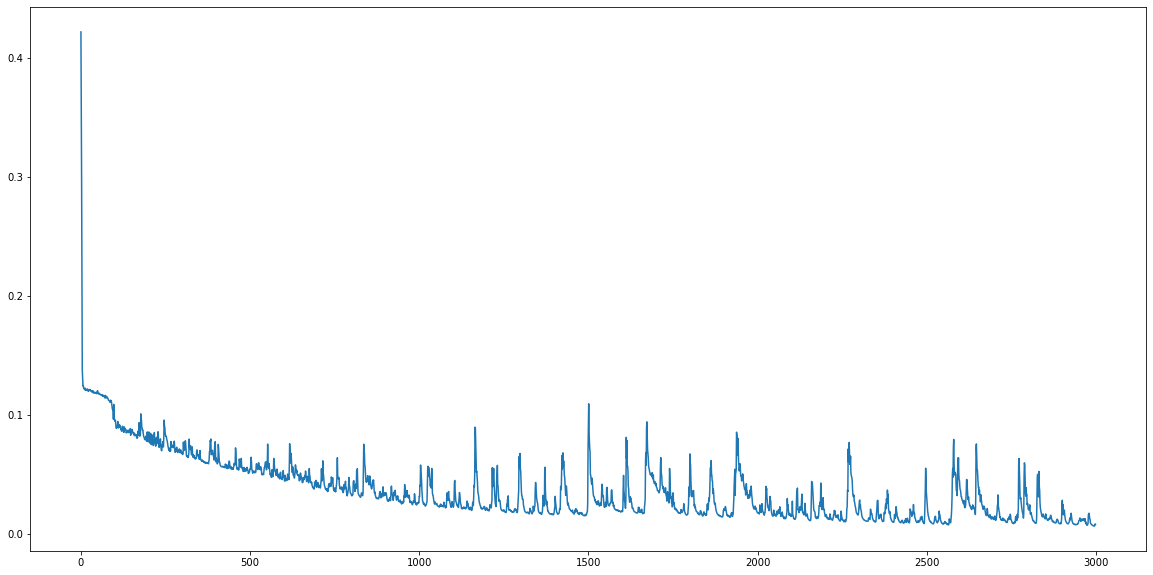

In [70]:
fig = plt.figure(figsize = (20,10))
plt.plot(train_loss_avg) 
plt.show()

(0.0, 0.05917807295918465)

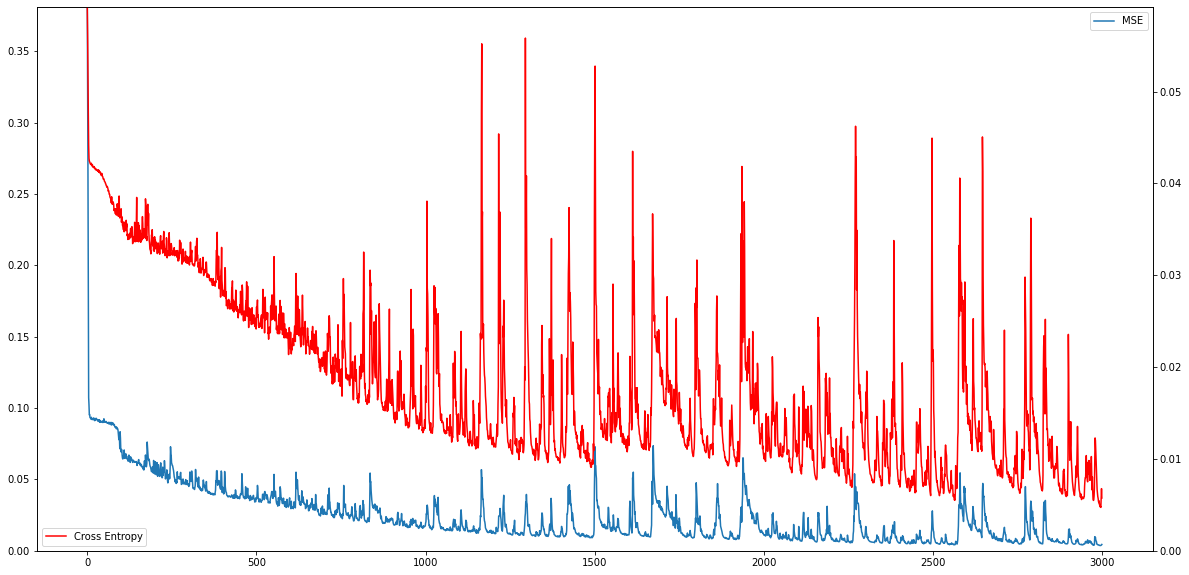

In [71]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(mse_avg, label="MSE")
ax2 = ax.twinx()
ax2.plot(ce_avg, color="red", label="Cross Entropy")
ax.legend(loc=1)
ax.set_ylim(0, max(mse_avg))
ax2.legend(loc=3)
ax2.set_ylim(0, max(ce_avg))

In [197]:
leafencoder = LeafEncoder(hidden_size=32, feature_size=128).to(device)
nonleafenc = NonLeafEncoder(hidden_size=32, feature_size=128).to(device)
encoder = Encoder(leafenc, nonleafenc).to(device)
decoder = Decoder(latent_size=128, hidden_size=256).to(device)
classifier = NodeClassifier(latent_size=128, hidden_size=256).to(device)

checkpoint = torch.load("outputs/best_model.pth")
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
classifier.load_state_dict(checkpoint['classifier_state_dict'])
epoch = checkpoint['epoch']
print("epoch", epoch)

epoch 2978


In [201]:
input = deserialize(iter(data_loader).next()[0])
normalize_features(input)

encoded = encoder(input).to(device)
decoded = decode_testing(encoded, 150)
count = []
numerar_nodos(decoded, count)


C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rad = torch.tensor(input.radius)
C:\Users\User\AppData\Local\Temp\ipykernel_9612\3960003241.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  radius = self.l1(torch.tensor(input.radius).reshape(1,4).to(device))


In [202]:
plotTree(decoded, True)


nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4954124…

In [200]:
edges = plotTree(input, False)

nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

In [520]:
plotTree(decoded, True)

ValueError: None cannot be a node

In [171]:
plotTree(decoded, True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5164646…

In [172]:
plotTree(input, False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…